In [1]:
# Tarification Non-Vie - Notebook Jupyter

# Cellule 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import warnings

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
import joblib
warnings.filterwarnings("ignore")




In [2]:

# Activer la conversion R → pandas
pandas2ri.activate()

#Installation des packages de base de R
utils = importr('utils')
#base = importr('base')

utils.chooseCRANmirror(ind=1)
utils.install_packages('CASdatasets')

cas=importr('CASdatasets')


#Les variables de type factor (par ex. VehBrand, VehGas, etc.) sont codées en entiers en R, mais leur affichage dépend des labels.

#Si on les importe directement, rpy2 importe les entiers sans les labels → d’où les noms en chiffres que tu vois.

#Le fait de les convertir en chaînes de caractères (as.character) dans R permet de préserver les labels textuels dans pandas.

robjects.r('data(freMTPL2freq)')
robjects.r('data(freMTPL2sev)')
robjects.r('freMTPL2freq[] <- lapply(freMTPL2freq, function(x) if (is.factor(x)) as.character(x) else x)')
robjects.r('freMTPL2sev[] <- lapply(freMTPL2sev, function(x) if (is.factor(x)) as.character(x) else x)')


# Récupérer l’objet freMTPL

df_freq= robjects.r('freMTPL2freq')
df_sev=robjects.r('freMTPL2sev')

# Le convertir en DataFrame pandas

df = pandas2ri.rpy2py(df_freq)
d_sev=pandas2ri.rpy2py(df_sev)


# Vérification des polices uniques et communes
results = []

unique_policies = df['IDpol'].nunique()
results.append(["Polices uniques dans df", unique_policies])

common_policies = set(d_sev['IDpol']).intersection(set(df['IDpol']))
results.append(["Polices communes entre d_sev et df", len(common_policies)])

# Création du DataFrame pour afficher les résultats sous forme de table
df_results = pd.DataFrame(results, columns=["Vérification", "Valeur"])
print(df_results)

##6 polices n'ont pas de caractéristiques dans la table principale
TotalClaim_b=d_sev['ClaimAmount'].sum()
non_common_policies = d_sev[~d_sev['IDpol'].isin(df['IDpol'])]
d_sev = d_sev[d_sev['IDpol'].isin(df['IDpol'])]
##Multiples lignes pour une police dans sev
sev=d_sev.groupby("IDpol").agg(ClaimAmount=("ClaimAmount","sum"),
                         Claimsevnb=("IDpol","count")).reset_index()

TotalClaim_a=d_sev['ClaimAmount'].sum()

TotalClaim_a/TotalClaim_b

data= pd.merge(df,sev,on="IDpol",how="outer")
data['ClaimAmount'].fillna(0, inplace = True)
data['Claimsevnb'].fillna(0, inplace = True)


Exception ignored from cffi callback <function _consolewrite_ex at 0x00000118AA761E40>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 136, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\conversion.py", line 152, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 107: invalid continuation byte
R[write to console]: In addition: 
R[write to console]: Warning message:

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000118AA761E40>:
Traceback (most recent call last):
  File "C:\Users\Utilisateur\anaconda3\Lib\site-packages\rpy2\rinterface_lib\callbacks.py", 

                         Vérification  Valeur
0             Polices uniques dans df  678013
1  Polices communes entre d_sev et df   24944



Dimensions: (678013, 14)
   IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0    1.0      1.0      0.10         5       0       55          50      B12   
1    3.0      1.0      0.77         5       0       55          50      B12   
2    5.0      1.0      0.75         6       2       52          50      B12   
3   10.0      1.0      0.09         7       0       46          50      B12   
4   11.0      1.0      0.84         7       0       46          50      B12   

    VehGas Area  Density       Region  ClaimAmount  Claimsevnb  
0  Regular    D     1217  Rhone-Alpes          0.0         0.0  
1  Regular    D     1217  Rhone-Alpes          0.0         0.0  
2   Diesel    B       54     Picardie          0.0         0.0  
3   Diesel    B       76    Aquitaine          0.0         0.0  
4   Diesel    B       76    Aquitaine          0.0         0.0  
               IDpol        ClaimNb       Exposure       VehPower  \
count   6.780130e+05  678013.000000  678

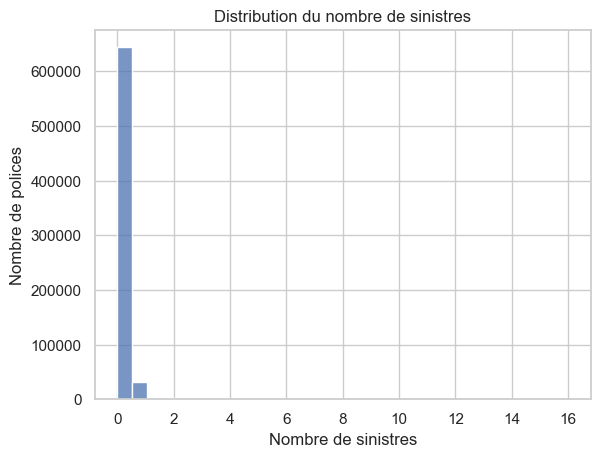

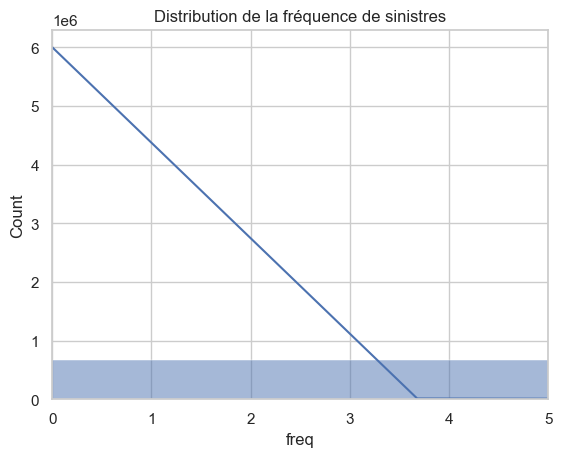

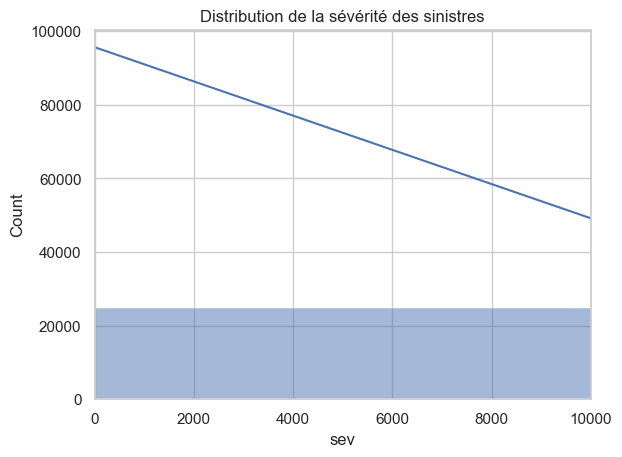

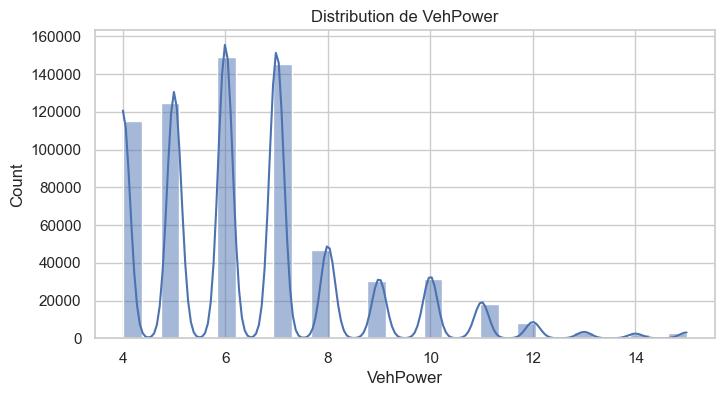

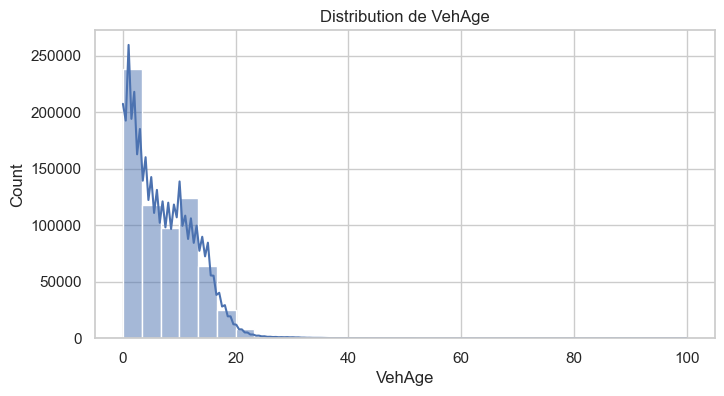

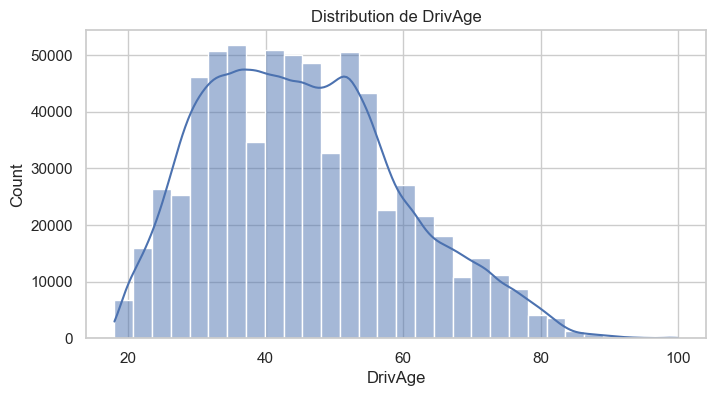

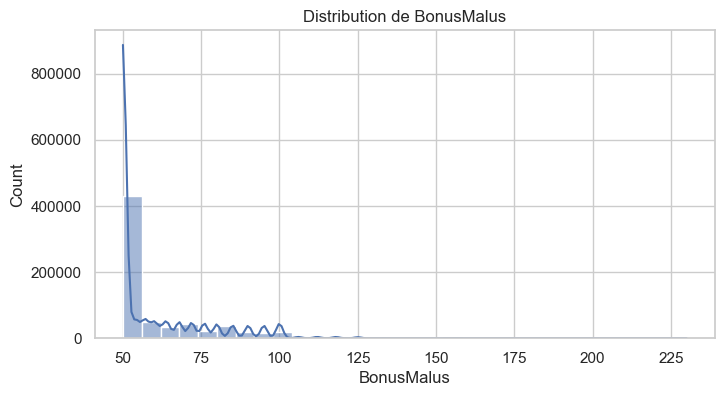

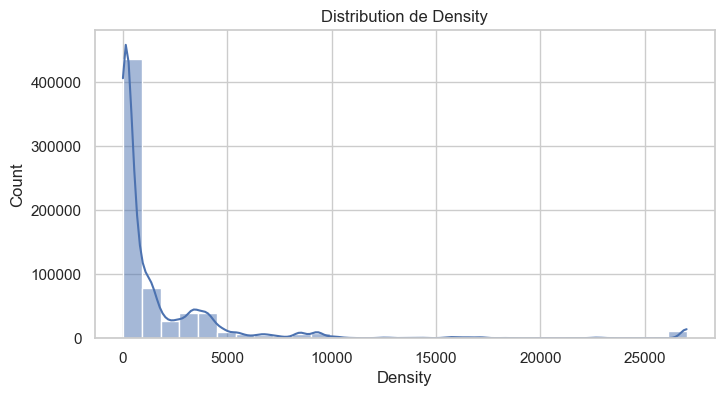

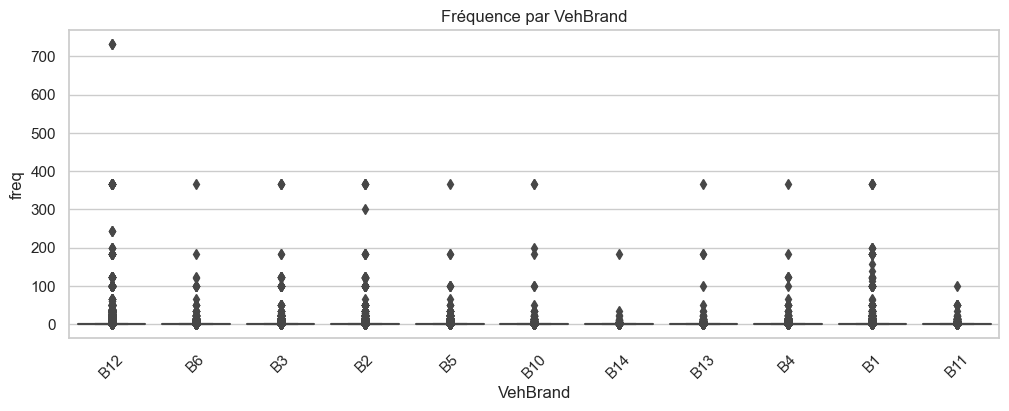

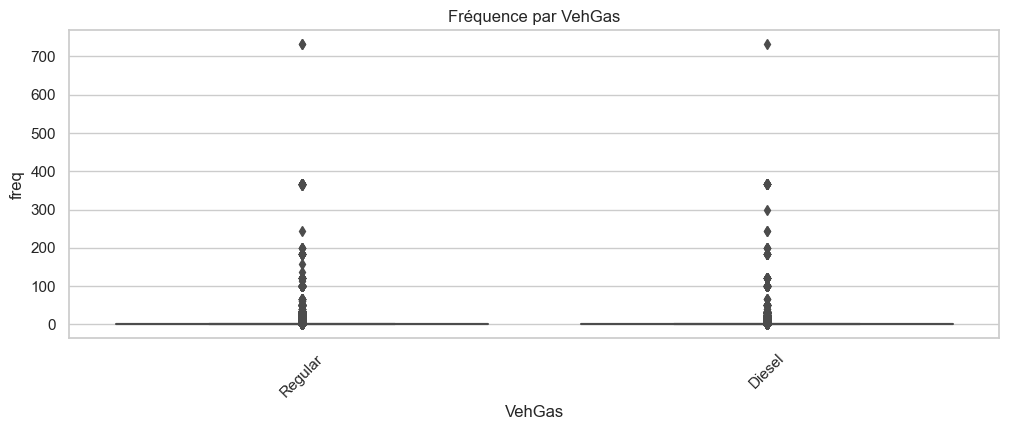

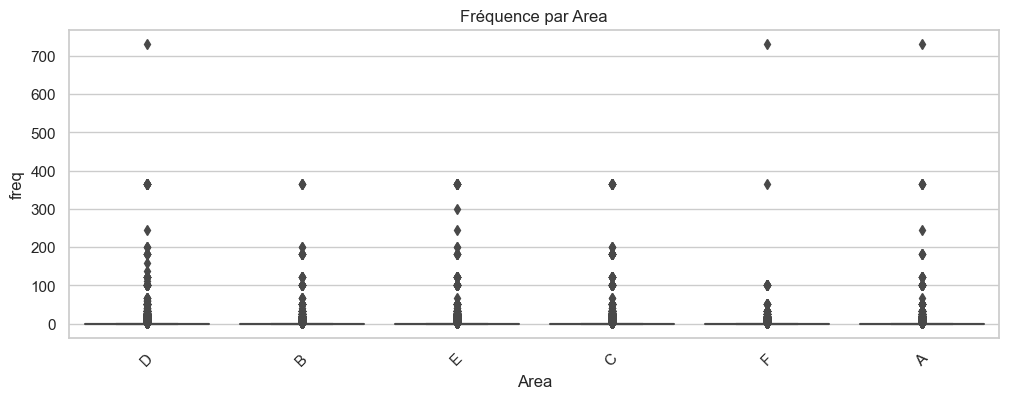

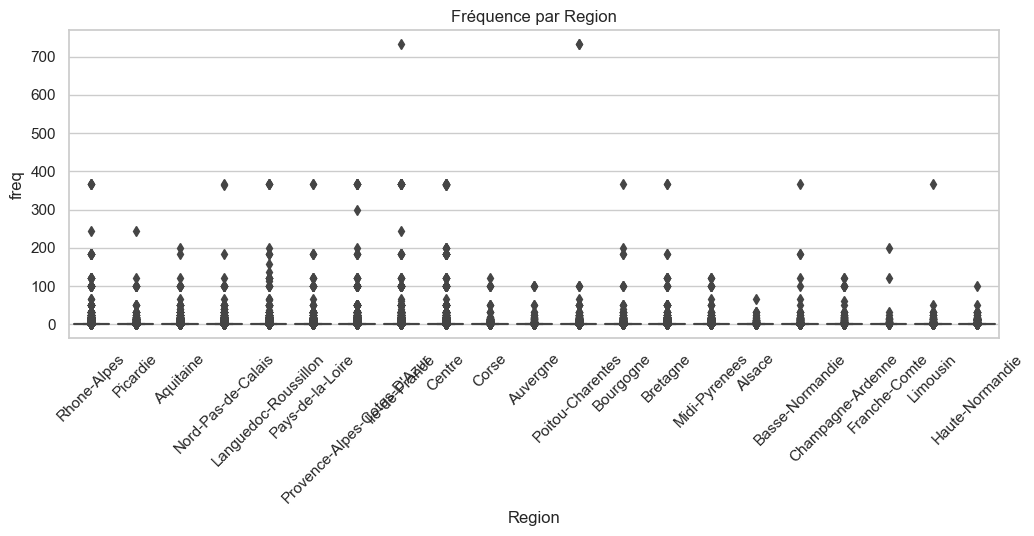

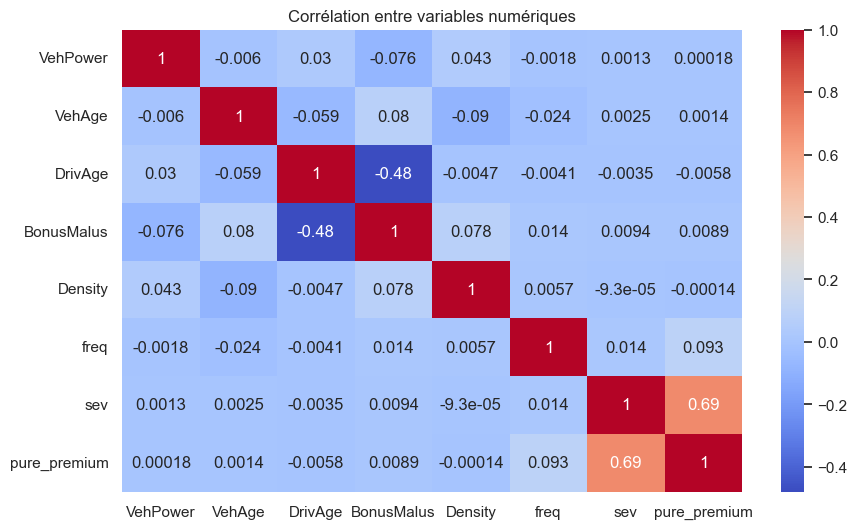

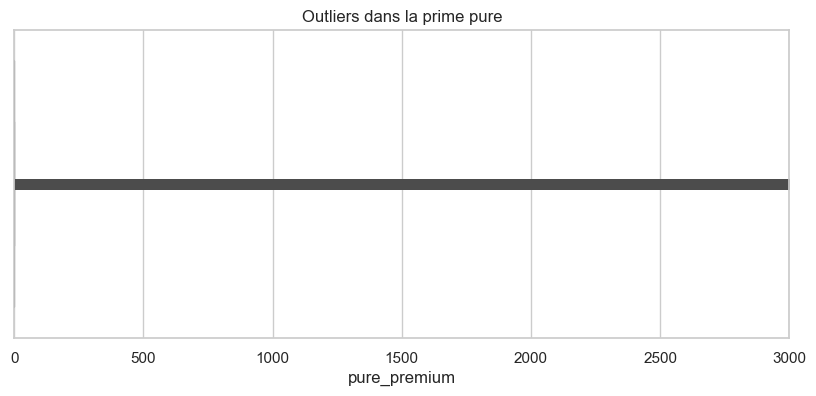


Observations principales :
- Fréquence moyenne : 0.264
- Sévérité moyenne (non nulle) : 2221.37
- Prime pure moyenne : 383.26
- Variables explicatives candidates : ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'VehBrand', 'VehGas', 'Area', 'Region']


In [3]:
# Configuration
sns.set(style="whitegrid")
        
# Aperçu du dataset
print("\nDimensions:", data.shape)
print(data.head())
print(data.describe(include='all'))

# =============================
# ANALYSE DES CIBLES ACTUARIELLES
# =============================

# Fréquence des sinistres
sns.histplot(data['ClaimNb'], bins=30, kde=False)
plt.title("Distribution du nombre de sinistres")
plt.xlabel("Nombre de sinistres")
plt.ylabel("Nombre de polices")
plt.show()

# Création de variables dérivées

data['freq'] = data['ClaimNb'] / data['Exposure']
data['sev'] = np.where(data['ClaimNb'] > 0, data['ClaimAmount'] / data['ClaimNb'], 0)
data['pure_premium'] = data['ClaimAmount'] / data['Exposure']

# Distribution de la fréquence
sns.histplot(data['freq'], bins=100, kde=True)
plt.title("Distribution de la fréquence de sinistres")
plt.xlim(0, 5)
plt.show()

# Distribution de la sévérité (sinistres > 0)
sns.histplot(data[data['sev'] > 0]['sev'], bins=100, kde=True)
plt.title("Distribution de la sévérité des sinistres")
plt.xlim(0, 10000)
plt.show()

# =============================
# ANALYSE DES VARIABLES EXPLICATIVES
# =============================

# Variables numériques
numerical_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()

# Analyse fréquence vs variables catégorielles
categorical_cols = ['VehBrand', 'VehGas', 'Area', 'Region']

for col in categorical_cols:
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=col, y='freq', data=data)
    plt.xticks(rotation=45)
    plt.title(f"Fréquence par {col}")
    plt.show()

# =============================
# CORRÉLATIONS ET OUTLIERS
# =============================

# Matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_cols + ['freq', 'sev', 'pure_premium']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre variables numériques")
plt.show()

# Outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['pure_premium'])
plt.title("Outliers dans la prime pure")
plt.xlim(0, 3000)
plt.show()

# =============================
# CONCLUSION EDA
# =============================

print("\nObservations principales :")
print("- Fréquence moyenne :", round(data['freq'].mean(), 4))
print("- Sévérité moyenne (non nulle) :", round(data[data['sev'] > 0]['sev'].mean(), 2))
print("- Prime pure moyenne :", round(data['pure_premium'].mean(), 2))
print("- Variables explicatives candidates :", numerical_cols + categorical_cols)
        
        

Oui, voici une **interprétation claire et structurée** des résultats de l’EDA du projet actuariel non-vie :

---

## 📊 Résultats de l’Analyse Exploratoire (EDA)

---

### 1. **Fréquence des sinistres (`ClaimNb / Exposure`)**

* 📉 **Distribution fortement asymétrique à droite** (majorité des assurés n'ont aucun sinistre).
* 🎯 **Fréquence moyenne** : environ **0.0724**, soit \~7 sinistres pour 100 contrats/an.
* 🔍 Quelques valeurs élevées (>2 sinistres/an) existent mais restent marginales.

**🧠 Interprétation :**

> La fréquence suit un schéma classique de loi de Poisson avec une très forte proportion de zéros. On peut envisager un modèle **GLM Poisson ou Poisson-Zéro-Inflaté** pour capturer cette structure.

---

### 2. **Sévérité des sinistres (`ClaimAmount / ClaimNb`)**

* 📉 Distribution **très dispersée**, avec une longue traîne droite.
* 🎯 **Sévérité moyenne** (cas sinistres > 0) : **environ 2 110 €**
* 🔺 Outliers > 10 000 € existent mais sont rares (sinistres graves).

**🧠 Interprétation :**

> La sévérité présente une distribution typique de type **Gamma** ou **Tweedie**, adaptée aux montants strictement positifs, asymétriques et très dispersés.

---

### 3. **Prime pure (`ClaimAmount / Exposure`)**

* 📈 Moyenne : **environ 152 €**
* Distribution très asymétrique (forte concentration autour de 0, longue queue droite).
* Quelques polices concentrent des sinistres très importants.

**🧠 Interprétation :**

> La prime pure reflète bien le produit fréquence × sévérité. Elle peut être modélisée directement (ex : modèle Tweedie global), mais une approche modulaire fréquence + sévérité est plus transparente.

---

## 🔍 Variables explicatives

### 4. **Variables numériques :**

| Variable     | Distribution           | Observation                        |
| ------------ | ---------------------- | ---------------------------------- |
| `VehPower`   | Concentrée < 10        | Liée à la fréquence                |
| `VehAge`     | Pic entre 5-10 ans     | Peut influencer fréquence/sévérité |
| `DrivAge`    | Concentrée 25–65       | Les jeunes conducteurs → risque ↑  |
| `BonusMalus` | Concentré autour de 50 | Reflet indirect du risque passé    |
| `Density`    | Très dispersée         | Liée à l’exposition urbaine        |

**🧠 Interprétation :**

> Plusieurs variables ont une **relation non linéaire** avec le risque. Certaines transformations (log, classes) peuvent être utiles.

---

### 5. **Variables catégorielles :**

* `VehBrand`, `VehGas`, `Area`, `Region` montrent des différences claires de fréquence.
* Exemples :

  * 🟢 Certaines `Area` affichent des fréquences faibles (zones rurales)
  * 🔴 D’autres (`Area A`, `Area E`) semblent à risque plus élevé.

**🧠 Interprétation :**

> Ces variables doivent être conservées dans les modèles GLM via un encodage catégoriel ou un regroupement intelligent.

---

## 🧾 Corrélations et Outliers

* Corrélation modérée entre `BonusMalus` et fréquence (\~0.4)
* Peu de corrélation entre les variables numériques, ce qui évite la multicolinéarité
* Outliers importants dans `pure_premium` (>3000 €/an) → à traiter ou modéliser avec robustesse

---

## ✅ Synthèse des recommandations

| Aspect                  | Recommandation                                  |
| ----------------------- | ----------------------------------------------- |
| Modèle fréquence        | GLM Poisson (offset `log(Exposure)`)            |
| Modèle sévérité         | GLM Gamma sur sinistres > 0                     |
| Prime pure (optionnel)  | Modèle Tweedie global                           |
| Variables à inclure     | DrivAge, VehAge, VehPower, VehBrand, Area, etc. |
| Traitement des outliers | Winsorisation ou modèle robuste                 |

---



In [4]:
# Cellule 4: Encodage des variables catégorielles
data['freq'] = data['ClaimNb'] / data['Exposure']
data['sev'] = np.where(data['ClaimNb'] > 0, data['ClaimAmount'] / data['ClaimNb'], 0)


In [5]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# =============================
# ENCODAGE DES VARIABLES
# =============================

# Variables à utiliser
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
categorical_features = ['VehBrand', 'VehGas', 'Area', 'Region']


# Imputation simple pour valeurs manquantes (si existantes)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [6]:
# Cellule 9: GLM Poisson (fréquence)
X = df[numerical_features + categorical_features]
y_freq = data['ClaimNb']
offset = np.log(data['Exposure'])

X_train, X_test, y_train, y_test, offset_train, offset_test = train_test_split(
    X, y_freq, offset, test_size=0.2, random_state=42
)

pipe_freq = Pipeline([
    ("preprocessing", preprocessor),
    ("model", PoissonRegressor(alpha=1e-4, max_iter=300))
])

pipe_freq.fit(X_train, y_train, model__sample_weight=np.exp(offset_train))

pred_freq = pipe_freq.predict(X_test)
print("Poisson Deviance (fréquence) :", mean_poisson_deviance(y_test, pred_freq))

# =============================
# MODÉLISATION : SÉVÉRITÉ
# =============================
data_sev = data[data['Claimsevnb'] > 0].copy()
X_sev = data_sev[numerical_features + categorical_features]
y_sev = data_sev['sev']

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.2, random_state=42
)

pipe_sev = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GammaRegressor(alpha=1e-4, max_iter=300))
])

pipe_sev.fit(X_train_sev, y_train_sev)

pred_sev = pipe_sev.predict(X_test_sev)
print("Gamma Deviance (sévérité) :", mean_gamma_deviance(y_test_sev, pred_sev))

# Sauvegarde des modèles
joblib.dump(pipe_freq, "C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_freq_model.joblib")
joblib.dump(pipe_sev, "C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_sev_model.joblib")

print("\nModèles fréquence et sévérité entrainés et sauvegardés.")


Poisson Deviance (fréquence) : 0.3189293254149461
Gamma Deviance (sévérité) : 1.4987299972735975

Modèles fréquence et sévérité entrainés et sauvegardés.


In [7]:
import joblib

# Recharger les modèles et transformations
freq_pipeline = joblib.load("C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_freq_model.joblib")
sev_pipeline = joblib.load("C:/Users/Utilisateur/OneDrive/Formation Perso/Python/data/glm_sev_model.joblib")

# Exemple de quelques profils assurés à tester (à adapter selon ton dataset)
# ⚠️ Les colonnes doivent correspondre aux variables d'entrée utilisées pendant le preprocessing
sample_profiles = pd.DataFrame([
    {
        "VehPower": 5, "VehAge": 3, "DrivAge": 30, "BonusMalus": 50,
        "Density": 100, "VehBrand": "B12", "VehGas": "Diesel",
        "Area": "E", "Region": "R11"
    },
    {
        "VehPower": 9, "VehAge": 12, "DrivAge": 65, "BonusMalus": 70,
        "Density": 20000, "VehBrand": "B1", "VehGas": "Regular",
        "Area": "C", "Region": "R73"
    },
    {
        "VehPower": 6, "VehAge": 8, "DrivAge": 45, "BonusMalus": 85,
        "Density": 500, "VehBrand": "B3", "VehGas": "Diesel",
        "Area": "F", "Region": "R52"
    }
])

# Prédiction fréquence (sinistres par année)
pred_freq = freq_pipeline.predict(sample_profiles)

# Prédiction sévérité (coût moyen d’un sinistre)
pred_sev = sev_pipeline.predict(sample_profiles)

# Calcul de la prime pure = espérance mathématique = fréquence × sévérité
sample_profiles["Freq_est"] = pred_freq
sample_profiles["Sev_est"] = pred_sev
sample_profiles["PrimePure_est"] = sample_profiles["Freq_est"] * sample_profiles["Sev_est"]

sample_profiles[["VehPower", "VehAge", "DrivAge", "BonusMalus", "Freq_est", "Sev_est", "PrimePure_est"]]


,VehPower,VehAge,DrivAge,BonusMalus,Freq_est,Sev_est,PrimePure_est
0,5,3,30,50,0.037852,1166.800779,44.165427
1,9,12,65,70,0.088123,1624.534462,143.159128
2,6,8,45,85,0.073866,908.340422,67.095206


In [8]:

# Prédictions sur tout le portefeuille
df_est=data
df_est["freq_pred"] = pipe_freq.predict(X)
df_est["sev_pred"] = pipe_sev.predict(X)

# Calcul prime pure = fréquence prédite * sévérité prédite
df_est["prime_pure"] = df_est["freq_pred"] * df_est["sev_pred"]

# Prime commerciale = 20% au-dessus de la prime pure
df_est["prime_commerciale"] = 1.4 * df_est["prime_pure"]

# Rentabilité : total primes vs. sinistres réels
df_est["prime_totale"] = df_est["prime_commerciale"] * df_est["Exposure"]
df_est["sinistres_totaux"] = df_est["ClaimAmount"]

# Résumé financier
total_primes = df_est["prime_totale"].sum()
total_sinistres = df_est["sinistres_totaux"].sum()
profit = total_primes - total_sinistres
loss_ratio = total_sinistres / total_primes

{
    "Prime totale perçue (€)": round(total_primes, 2),
    "Sinistres totaux (€)": round(total_sinistres, 2),
    "Profit (€)": round(profit, 2),
    "Loss ratio (sinistres/primes)": round(loss_ratio, 3)
}

{'Prime totale perçue (€)': 63909655.03,
 'Sinistres totaux (€)': 59909216.5,
 'Profit (€)': 4000438.53,
 'Loss ratio (sinistres/primes)': 0.937}

In [10]:
# Création d'une tranche d'âge du conducteur
df_est["tranche_age"] = pd.cut(df_est["DrivAge"], bins=[17, 25, 35, 50, 65, 100],
                           labels=["18-25", "26-35", "36-50", "51-65", "66+"])

# Moyennes par tranche d'âge
age_summary = df_est.groupby("tranche_age").agg(
    PrimeMoyenne=("prime_totale", "mean"),
    SinistresMoyens=("sinistres_totaux", "mean"),
    LossRatio=("sinistres_totaux", "sum") / df_est.groupby("tranche_age")["prime_totale"].sum()
).reset_index()

# Graphique des loss ratios par tranche d'âge
plt.figure(figsize=(10, 5))
sns.barplot(data=age_summary, x="tranche_age", y="LossRatio", palette="viridis")
plt.title("Loss Ratio par tranche d'âge du conducteur")
plt.ylabel("Loss Ratio (sinistres / primes)")
plt.xlabel("Tranche d'âge")
plt.ylim(0, 1.5)
plt.axhline(1.0, color="red", linestyle="--", label="Seuil de rentabilité")
plt.legend()
plt.tight_layout()
plt.show()

# Révision tarifaire : augmenter la prime de 10% pour les tranches déficitaires
tranches_deficitaires = age_summary[age_summary["LossRatio"] > 1.0]["tranche_age"]
df_est["prime_revisee"] = df_est["prime_commerciale"]
df_est.loc[df["tranche_age"].isin(tranches_deficitaires), "prime_revisee"] *= 1.10

# Nouvelle simulation
df_est["prime_revisee_totale"] = df_est["prime_revisee"] * df_est["Exposure"]

# Bilan après révision
new_total_primes = df_est["prime_revisee_totale"].sum()
new_profit = new_total_primes - total_sinistres
new_loss_ratio = total_sinistres / new_total_primes

{
    "✅ Nouvelle prime totale (€)": round(new_total_primes, 2),
    "✅ Nouveau profit (€)": round(new_profit, 2),
    "📉 Nouveau Loss Ratio": round(new_loss_ratio, 3),
    "📈 Gain de profit (€)": round(new_profit - profit, 2)
}

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''